In [2]:
import requests
import pandas as pd
from datetime import datetime
from dotenv import load_dotenv
import os

load_dotenv()
API_KEY = os.getenv("FRED_API_KEY")

BASE_URL = "https://api.stlouisfed.org/fred/series/observations"
SERIES_IDS = {
    "Exports": "EXPCA",
    "Imports": "IMPCA",
    "Net_Exports": "NETEXP",
    "Import_Price_Index": "IR14270",
    "Trade_Balance_Goods": "BOPGTB" 
}

def fetch_fred_series(series_id, start_date="2000-01-01"):
    params = {
        "series_id": series_id,
        "api_key": API_KEY,
        "file_type": "json",
        "observation_start": start_date
    }
    response = requests.get(BASE_URL, params=params)
    if response.status_code != 200:
        print(f"Failed to fetch {series_id}: {response.status_code}")
        return pd.DataFrame()

    data = response.json()
    if "observations" not in data:
        print(f"No observations found for {series_id}")
        return pd.DataFrame()

    df = pd.DataFrame(data["observations"])
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    df["date"] = pd.to_datetime(df["date"])
    df = df[["date", "value"]].set_index("date")
    df.columns = [series_id]
    return df

# fetch all
all_series = []
for name, series_id in SERIES_IDS.items():
    print(f"Fetching: {name}")
    df = fetch_fred_series(series_id)
    if not df.empty:
        all_series.append(df)

# combine data frames
combined_df = pd.concat(all_series, axis=1)

print(combined_df.tail())
combined_df.to_csv("fred_trade_supplychain_data.csv")

Fetching: Exports
Fetching: Imports
Fetching: Net_Exports
Fetching: Import_Price_Index
Fetching: Trade_Balance_Goods
                   EXPCA         IMPCA   NETEXP  IR14270    BOPGTB
date                                                              
2024-10-01  30526.751427  34463.328989 -920.084    969.1  -98830.0
2024-11-01  28351.328185  33438.102056      NaN    989.4 -103967.0
2024-12-01  26989.036387  35457.098576      NaN    965.4 -123281.0
2025-01-01  27334.563954  38338.463539      NaN    972.3 -155820.0
2025-02-01  28317.924380  34924.705129      NaN    999.9 -146993.0


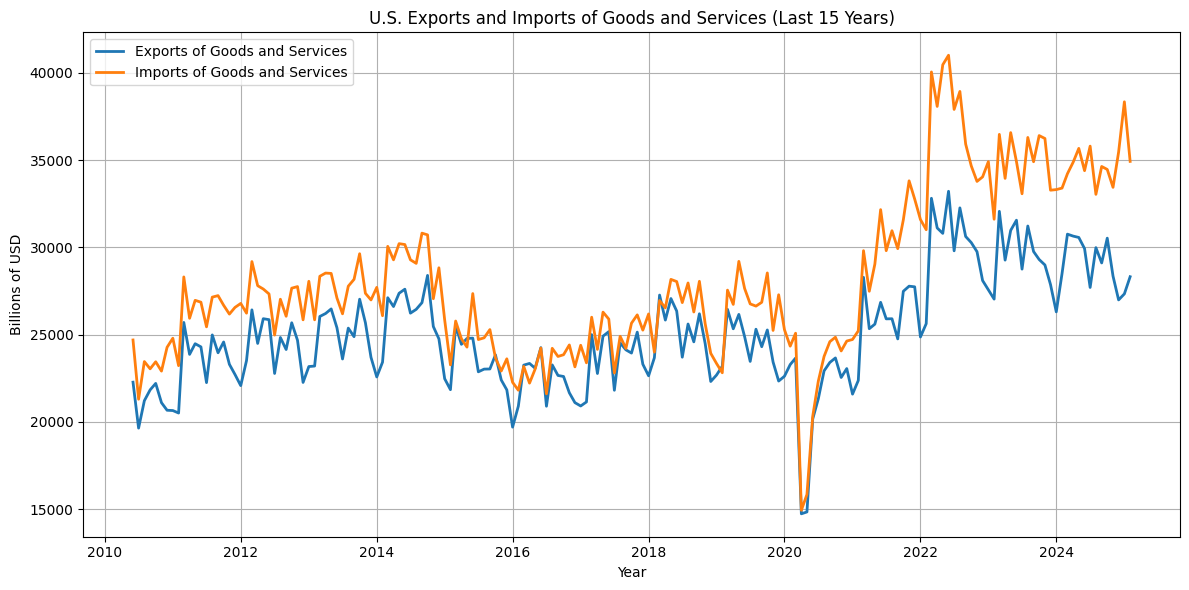

PPIACO not in dataset. Skipping Producer Price Index.


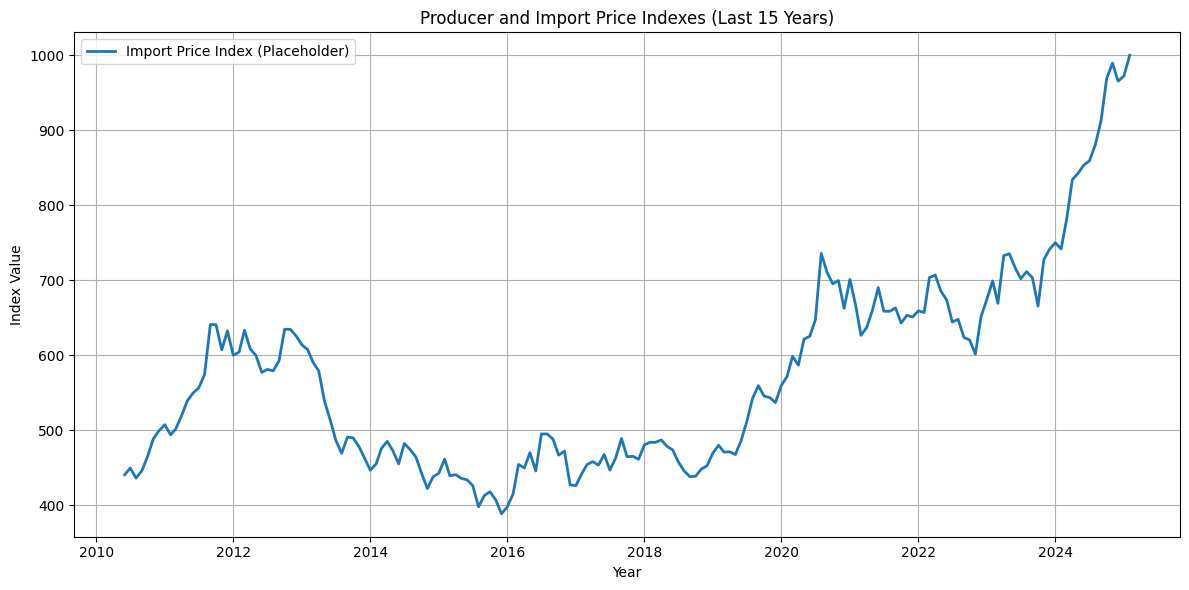

In [5]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

cutoff_date = datetime.today() - timedelta(days=15*365)
filtered_df = combined_df[combined_df.index >= cutoff_date]

plt.figure(figsize=(12, 6))
plt.plot(filtered_df["EXPCA"], label="Exports of Goods and Services", linewidth=2)
plt.plot(filtered_df["IMPCA"], label="Imports of Goods and Services", linewidth=2)
plt.title("U.S. Exports and Imports of Goods and Services (Last 15 Years)")
plt.xlabel("Year")
plt.ylabel("Billions of USD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Producer and Import Price Indexes

plt.figure(figsize=(12, 6))
if "PPIACO" in combined_df.columns:
    plt.plot(filtered_df["PPIACO"], label="Producer Price Index", linewidth=2)
else:
    print("PPIACO not in dataset. Skipping Producer Price Index.")

plt.plot(filtered_df["IR14270"], label="Import Price Index (Placeholder)", linewidth=2)
plt.title("Producer and Import Price Indexes (Last 15 Years)")
plt.xlabel("Year")
plt.ylabel("Index Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

               IPMAN  MoM_Change_%  YoY_Change_%
date                                            
2024-04-01   99.3696     -0.689887           NaN
2024-05-01  100.0424      0.677068           NaN
2024-06-01   99.9935     -0.048879           NaN
2024-07-01   99.3588     -0.634741           NaN
2024-08-01   99.9270      0.571867           NaN
2024-09-01   99.6108     -0.316431           NaN
2024-10-01   98.9959     -0.617303           NaN
2024-11-01   99.2006      0.206776           NaN
2024-12-01   99.7325      0.536186           NaN
2025-01-01   99.7361      0.003610      1.307480
2025-02-01  100.7806      1.047264      0.934424
2025-03-01  101.1119      0.328734      1.051370


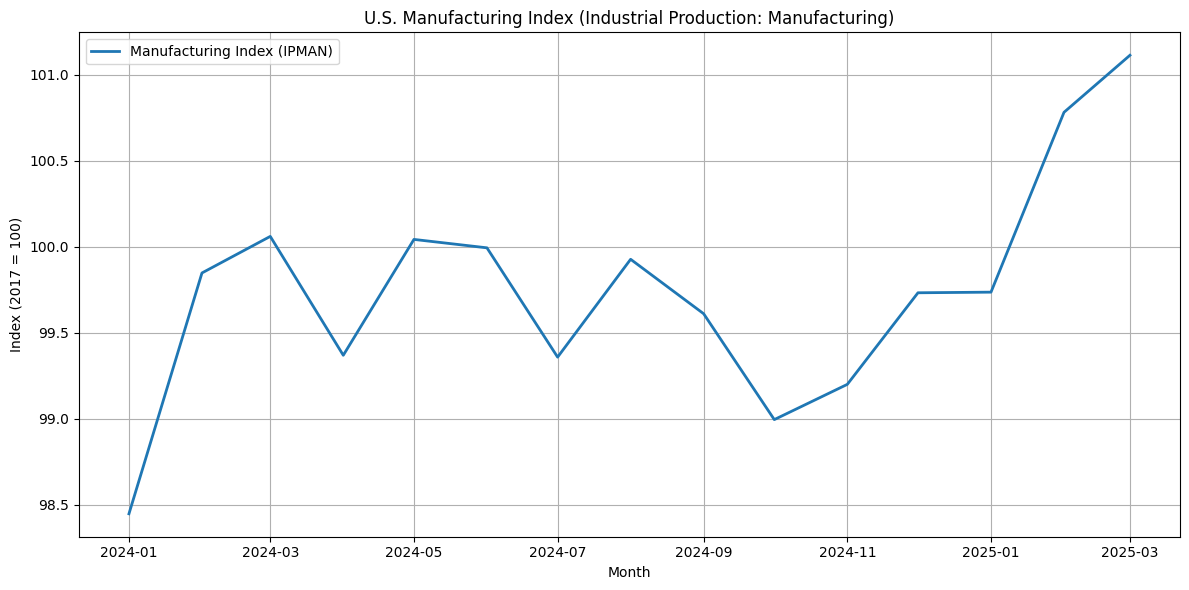

In [9]:
# Producer and Import Price Indexes 
# Fetch data
manufacturing_df = fetch_fred_series("IPMAN", start_date="2024-01-01")

# Month-on-Month Rate of Change (%)
manufacturing_df["MoM_Change_%"] = manufacturing_df["IPMAN"].pct_change(periods=1) * 100
# Year-on-Year Rate of Change (%)
manufacturing_df["YoY_Change_%"] = manufacturing_df["IPMAN"].pct_change(periods=12) * 100
print(manufacturing_df.tail(12))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(manufacturing_df.index, manufacturing_df["IPMAN"], label="Manufacturing Index (IPMAN)", linewidth=2)
plt.title("U.S. Manufacturing Index (Industrial Production: Manufacturing)")
plt.xlabel("Month")
plt.ylabel("Index (2017 = 100)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
